In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

os.getcwd()

'/home/anhnguyen/Documents/electricity_demand_prediction'

In [2]:
df = pd.read_csv('spain_energy_market.csv', parse_dates=["datetime"])
demand = df[df['name'] == 'Demanda real']['value'].tolist()
data = df[df['name'] == 'Demanda real']
data = data.rename(columns={"value": "energy"})

print(demand[:5], len(demand))

[28191.597222222223, 28465.18055555556, 26860.49305555556, 25333.597222222223, 23905.54166666667] 1825


In [3]:
#Normalize data
mean = sum(demand)/len(demand)
std = np.std(demand)
demand =[(x - mean)/std for x in demand]

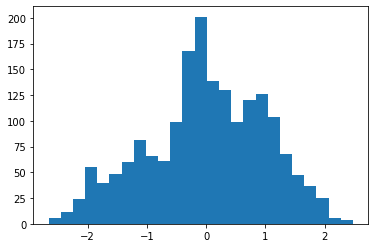

In [4]:
num_bins = 25
   
plt.hist(demand, num_bins)
plt.show()

1. Feature Engineering

In [5]:
data["date"] = data["datetime"].dt.date
data.set_index("date", inplace=True)
data = data.asfreq("D")

data

,datetime,id,name,geoid,geoname,energy
date,,,,,,
2014-01-01,2014-01-01 23:00:00,1293,Demanda real,NaN,NaN,28191.597222
2014-01-02,2014-01-02 23:00:00,1293,Demanda real,NaN,NaN,28465.180556
2014-01-03,2014-01-03 23:00:00,1293,Demanda real,NaN,NaN,26860.493056
2014-01-04,2014-01-04 23:00:00,1293,Demanda real,NaN,NaN,25333.597222
2014-01-05,2014-01-05 23:00:00,1293,Demanda real,NaN,NaN,23905.541667
...,...,...,...,...,...,...
2018-12-26,2018-12-26 23:00:00,1293,Demanda real,NaN,NaN,28521.423611
2018-12-27,2018-12-27 23:00:00,1293,Demanda real,NaN,NaN,28624.194444
2018-12-28,2018-12-28 23:00:00,1293,Demanda real,NaN,NaN,26632.840278


/tmp/ipykernel_8454/2495615302.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


<Figure size 1440x1152 with 0 Axes>

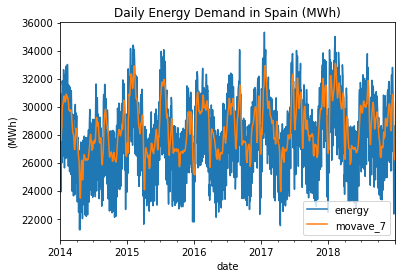

In [6]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["week"] = data.index.week
data["day"] = data.index.weekday
data["ix"] = range(0,len(data))

#Calculating the moving average and standard deviation base on week, month, quarter and year
data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
data[["movave_30", "movstd_30"]] = data.energy.rolling(30).agg([np.mean, np.std])
data[["movave_90", "movstd_90"]] = data.energy.rolling(90).agg([np.mean, np.std])
data[["movave_365", "movstd_365"]] = data.energy.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
data[["energy", "movave_7"]].plot(title="Daily Energy Demand in Spain (MWh)")
plt.ylabel("(MWh)")
plt.show()

In [7]:
data['target'] = demand

In [8]:
features = []
targets = []
tau = 30 #forecasting periods

#Shifting backwards targets by 1 to 30 days
for t in range(1, tau+1):
    data["target_t" + str(t)] = data.target.shift(-t)
    targets.append("target_t" + str(t))
    
#Lagging targets by 1 to 30 days
for t in range(1,31):
    data["feat_ar" + str(t)] = data.target.shift(t)
    features.append("feat_ar" + str(t))
        
#Get features as the moving average, std dev, min and max of the last week, fortnight and month
for t in [7, 14, 30]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = \
    data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
months.index = data.index
data = pd.concat([data, months], axis=1)

days = pd.get_dummies(data.day,
                              prefix="day",
                              drop_first=True)
days.index = data.index
data = pd.concat([data, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

In [9]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

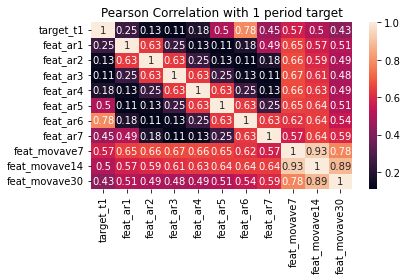

In [10]:
# Calculate correlation matrix
corr = data[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

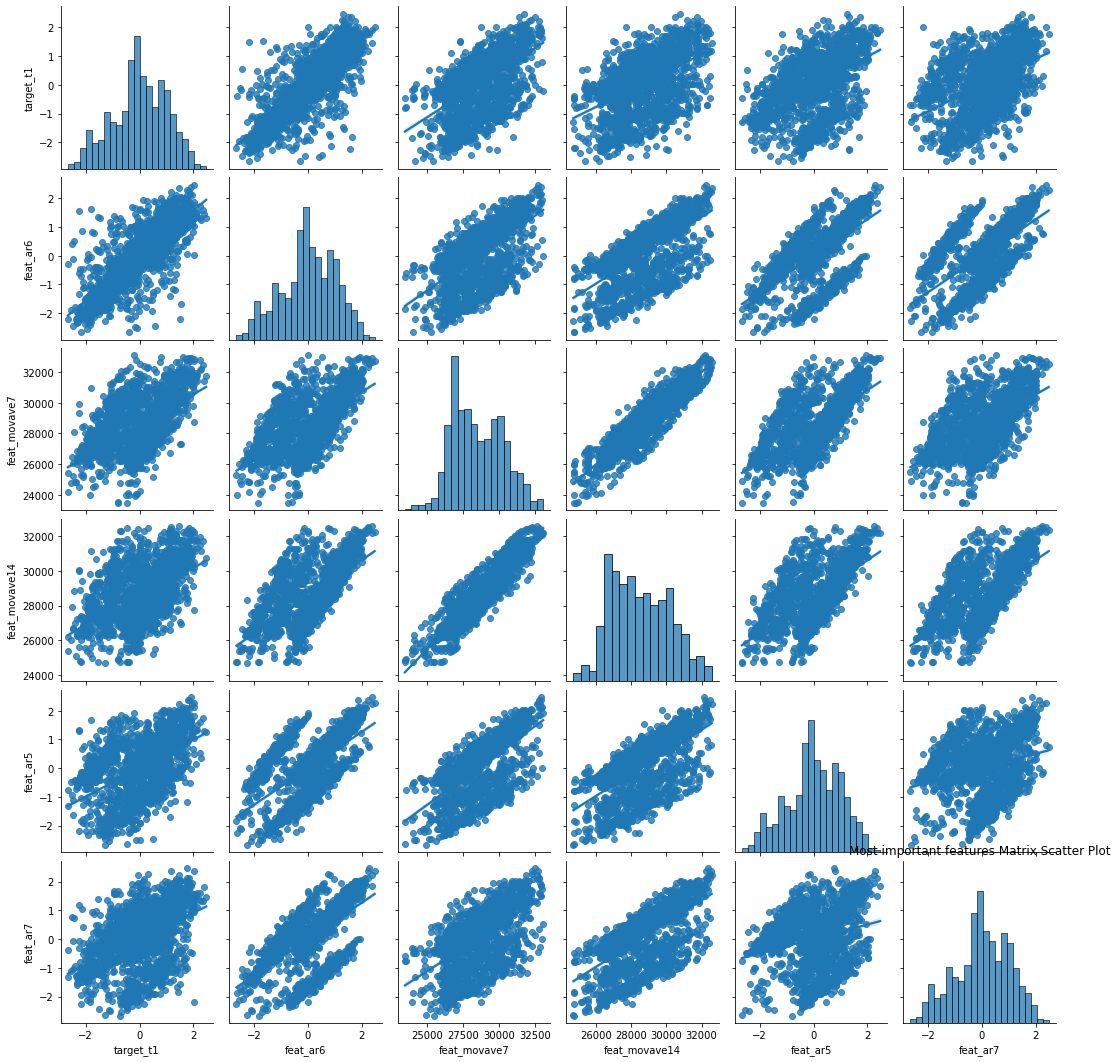

In [11]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

2. Split data

In [12]:
data_feateng = data[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

X_train = data_feateng.loc["2014":"2017"][features]
y_train = data_feateng.loc["2014":"2017"][targets]

X_test = data_feateng.loc["2018"][features]
y_test = data_feateng.loc["2018"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

Number of observations:  1765
Total number of observations:  1765
Train: (1431, 59)(1431, 30), 
Test: (334, 59)(334, 30)


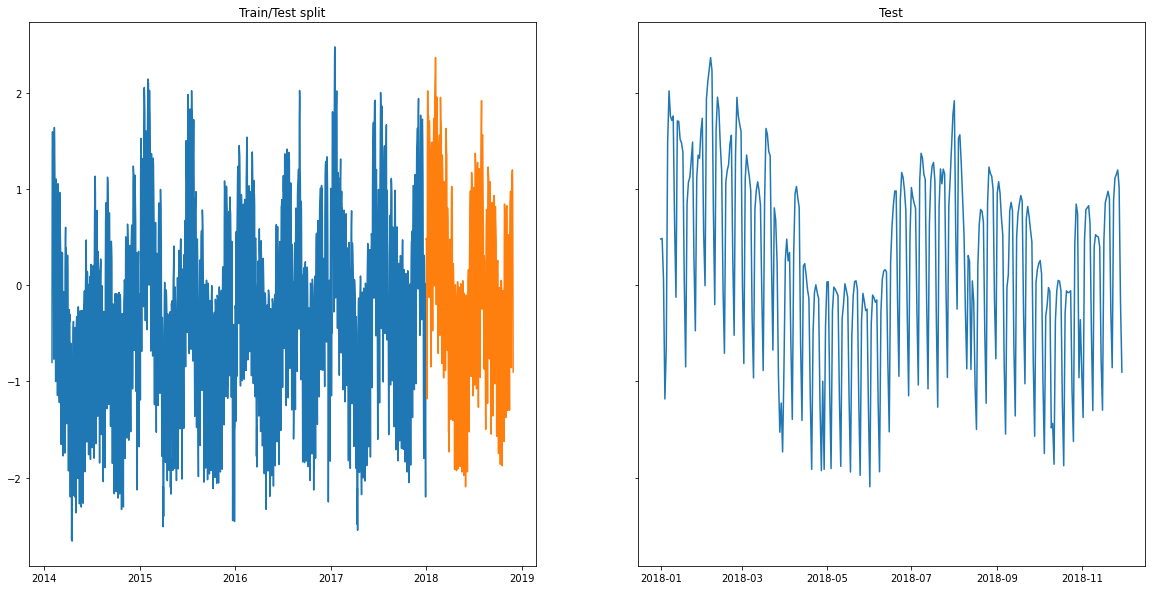

In [13]:
def visualize_model_on_testset(pred_array = None):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (20,10))

    ax1.plot(y_train.index, y_train.target_t1.values, label="train")
    ax1.plot(y_test.index, y_test.target_t1.values, label="test")
    if(pred_array is not None):
        ax1.plot(y_test.index, pred_array, label="test")
    ax1.title.set_text("Train/Test split")
    
    ax2.plot(y_test.index, y_test.target_t1.values, label="test")
    if(pred_array is not None):
        ax2.plot(y_test.index, pred_array, label="test")
    ax2.title.set_text("Test")
    
    plt.show()
    
    
visualize_model_on_testset()

3. Model fitting

Train RMSE: 0.3156364232683079
Test RMSE: 0.2796532638571441


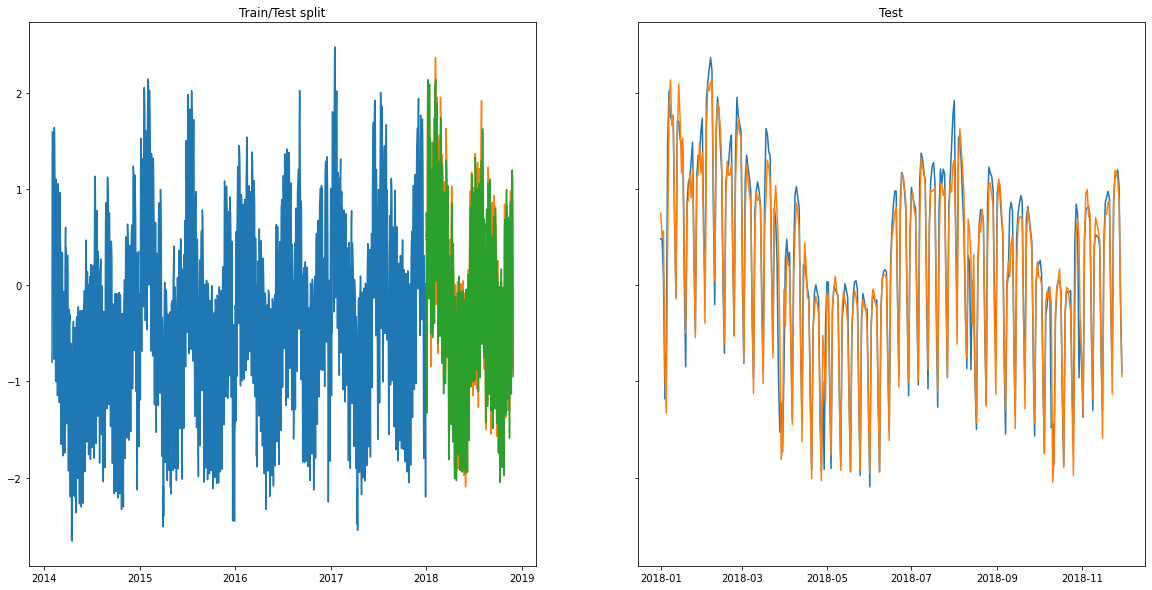

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )
visualize_model_on_testset(pred_array = p_test)

In [43]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(
    max_depth=8,
    n_estimators=8,
    learning_rate=0.5
)
regressor.fit(X_train, y_train["target_t1"])

errors = [mean_squared_error(y_test["target_t1"], y_pred) for y_pred in regressor.staged_predict(X_test)]
print(errors)
best_n_estimators = np.argmin(errors) + 1
print(best_n_estimators)

[0.381002988697573, 0.211346681705742, 0.16970260788058217, 0.15611605945778986, 0.15227436897852303, 0.14864571162153825, 0.1487708111653267, 0.14815104504229248]
8


Train RMSE: 0.07205268010002427
Test RMSE: 0.38952203220108944


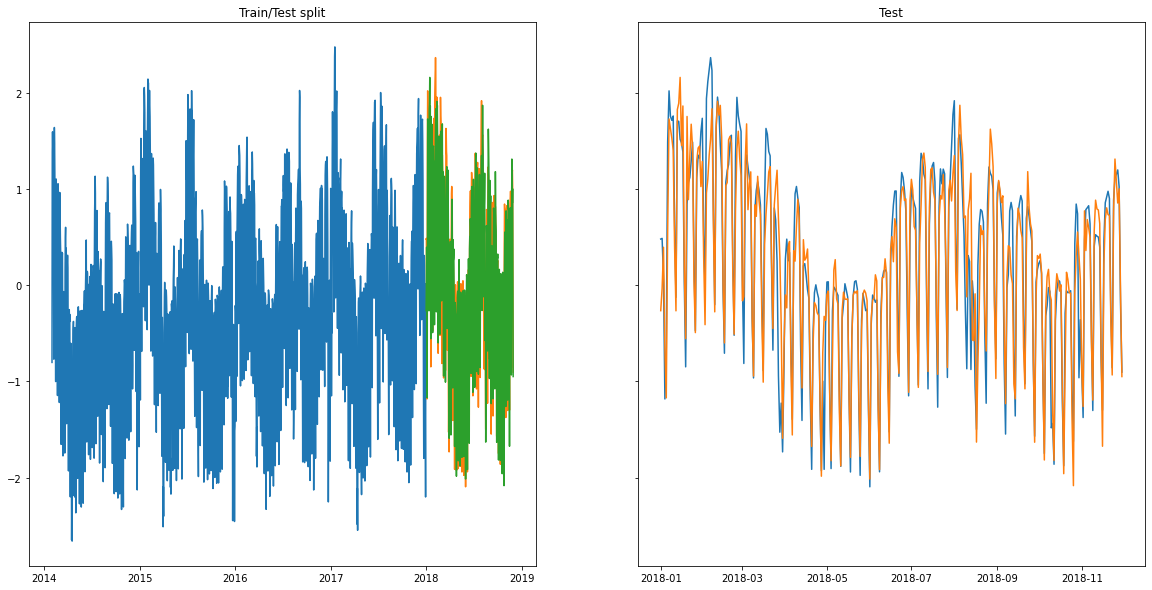

In [44]:
best_GradientBooster = GradientBoostingRegressor(
    max_depth=8,
    n_estimators=best_n_estimators,
    learning_rate=0.5
)
best_GradientBooster.fit(X_train, y_train['target_t1'])
y_pred_test = best_GradientBooster.predict(X_test)
y_pred_train = best_GradientBooster.predict(X_train)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], y_pred_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )
visualize_model_on_testset(pred_array = y_pred_test)

In [64]:
y_train_array = np.array(y_train['target_t1'].tolist())
y_test_array = np.array(y_test['target_t1'].tolist())
# y_train_array = np.expand_dims(y_train_array,0)
# y_test_array = np.expand_dims(y_test_array,0)
print(y_train_array.shape, y_test_array.shape)

(1431,) (334,)


In [66]:
X_train_array = np.expand_dims(X_train.to_numpy(),1)
X_test_array = np.expand_dims(X_test.to_numpy(),1)
print(X_train_array.shape, X_test_array.shape)

(1431, 1, 59) (334, 1, 59)


In [67]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [68]:
n_steps = 1
n_features = 59

In [69]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')

In [70]:
LSTM_model.fit(X_train_array, y_train_array, epochs=200, verbose=0)

In [73]:
y_pred_train = LSTM_model.predict(X_train_array)
y_pred_test = LSTM_model.predict(X_test_array)

In [76]:
y_pred_test = y_pred_test.reshape(-1) 

In [79]:
y_pred_train = y_pred_train.reshape(-1) 

Train RMSE: 7.233579054628178
Test RMSE: 6.701032049439211


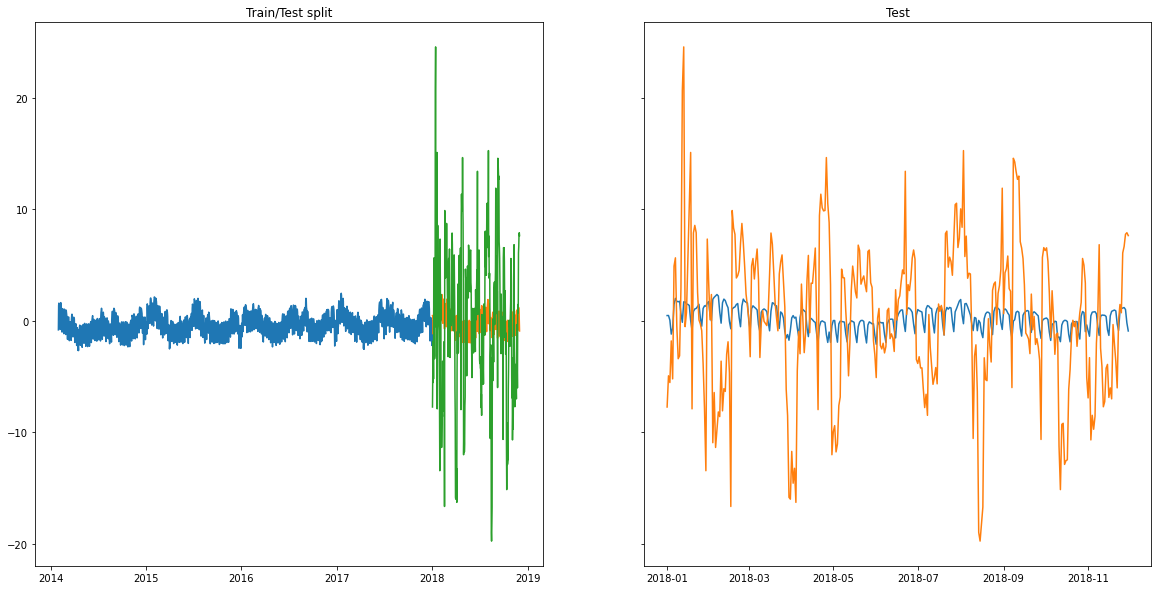

In [82]:
RMSE_train = np.sqrt(mean_squared_error(y_train_array, y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_test_array, y_pred_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )
visualize_model_on_testset(pred_array = y_pred_test)

In [83]:
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

In [85]:
print(mean, std)

28506.32214708489 2747.044356163866


In [88]:
p_train = [x* std + mean for x in p_train]
p_test = [x* std + mean for x in p_test]

y_test_array = [x*std + mean for x in y_test['target_t1'].tolist()]
y_train_array = [x*std + mean for x in y_train['target_t1'].tolist()]

In [90]:
from sklearn.metrics import mean_absolute_error

MAE_train = np.sqrt(mean_squared_error(y_train_array, p_train))
MAE_test = np.sqrt(mean_squared_error(y_test_array, p_test))

print("Train MAE: {}\nTest MAE: {}".format(MAE_train, MAE_test) )

Train MAE: 867.0672551389542
Test MAE: 768.2199201615721
